In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.


In [2]:
import os
import numpy as np
import cv2
import torch
import torchvision #images and videos
import torch.nn as nn # for functions in neural network
from tqdm import tqdm # to look for the progress
import random
import torchvision.transforms as transforms #data augmentation
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
PATH = "./Indian_road_data/Indian_road_data/"

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 30

[  0   2   3 255]


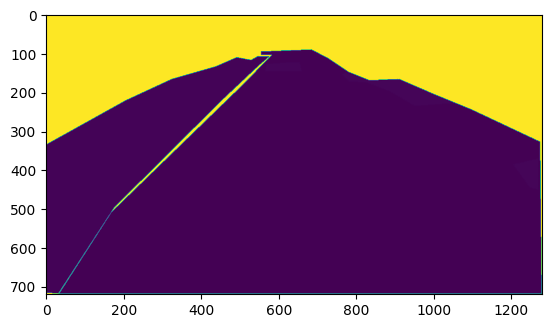

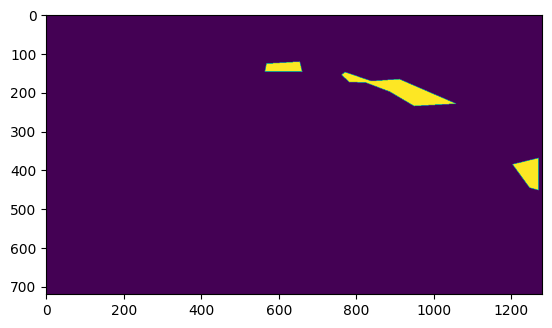

In [4]:
# List all files in the specified mask directory for training image 1_005
os.listdir(PATH + "/Masks/" + "train/" + "1_005")

# Read the mask image in grayscale mode (0 flag)
# The mask contains pixel-wise labels for different road features
img = cv2.imread(PATH + "/Masks/" + "train/" + "1_005/1_005_frame0007_gtFine_labelTrainIds.png", 0)

# Print unique values in the mask
# ravel() flattens the 2D image array to 1D for finding unique label values
print(np.unique(img.ravel()))  

# Display the original mask image
# Different colors represent different semantic segments
plt.imshow(img)
plt.show()

# Display binary mask for 'shallow' class
# (img == 3)*255 creates a binary mask where:
#   - Pixels with value 3 become 255 (white)
#   - All other pixels become 0 (black)
plt.imshow((img == 3)*255)

# Label encoding for semantic segmentation:
#0 - roads        # Main road surface
#1 - potholes     # Damaged sections of road
#2 - footpaths    # Pedestrian walking areas
#3 - shallow      # Shallow/minor surface irregularities
#255 - background # Non-road areas in the image

#### When resizing segmentation masks, it's important to be cautious: interpolation methods like cubic can introduce new pixel values that may not correspond to valid class labels, especially for masks with discrete class values. For segmentation masks, nearest neighbor interpolation (cv2.INTER_NEAREST) is often preferred to preserve the exact class labels.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# from np to tensor format

TRANSFORMS = transforms.Compose([transforms.ToPILImage(),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

labels = [0, 1, 2, 3]

def dataset_generator() :
    train_images = []
    train_labels = []
    valid_images = []
    valid_labels = []

    data = ["train", "val"]
    labels = [0, 1, 2, 3]

    for i in data:
        for j in os.listdir(PATH + "/Raw_images/" + str(i)) :
            for k in os.listdir(PATH + "/Raw_images/" + str(i) + "/" + str(j)) :
                cntn = random.randint(0,3)
                if cntn :
                    continue

                # Raw_images
                img = cv2.imread(PATH + "/Raw_images/" + str(i) + "/" + str(j) + "/" + str(k))
                img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_CUBIC)
                img = np.uint8(img)
                if i == "train" :
                    train_images.append(img)
                else :
                    valid_images.append(img)


                # Masks
                masks = []
                mask = cv2.imread(PATH + "/Masks/" + str(i) + "/" + str(j) + "/" + str(k).replace("leftImg8bit.jpg", "gtFine_labelTrainIds.png"))
                mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
                mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_CUBIC)
                mask = np.uint8(mask)

                for label in labels:
                    msk = (mask==label)*255
                    masks.append(msk)
                masks = np.transpose(masks)
                if i == "train" :
                    train_labels.append(masks)
                else :
                    valid_labels.append(masks)

            print("Image and Masks Extraction for " + str(j) + " is done...")

    train_images = np.array(train_images)
    valid_images = np.array(valid_images)
    train_labels = np.array(train_labels)
    valid_labels = np.array(valid_labels)

    return train_images, valid_images, train_labels, valid_labels


class create_dataset(Dataset) :
    def __init__(self, images, masks, transforms = None) :
        self.images = images
        self.labels = masks
        self.transforms = transforms

    def __len__(self) :
        return len(self.images)

    def __getitem__(self, index) :
        img = self.images[index]
        masks = self.labels[index]

        if self.transforms is not None :
            img = self.transforms(img)
            masks = self.transforms(masks)

        return img, masks


def load_dataset() :
    print("Dataset Generation started...")
    train_images, valid_images, train_labels, valid_labels = dataset_generator()

    print("Dataset Generated...")
    print(train_images.shape, valid_images.shape, train_labels.shape, valid_labels.shape)

    train_dataset = create_dataset(train_images, train_labels, TRANSFORMS)
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,
                                               num_workers = 1)
    print("Step 1 Crossed...")

    valid_dataset = create_dataset(valid_images, valid_labels, TRANSFORMS)
    valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,
                                               num_workers = 1)
    print("Step 2 Crossed...")
    print(valid_dataset)

    return train_loader, valid_loader

In [7]:
# Typical usage pattern:
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)  # Load pretrained model
model.classifier = torchvision.models.segmentation.deeplabv3.DeepLabHead(2048, 4)  # Replace classifier
# Now model will output segmentation maps with 4 classes instead of the original number of classes
model.to(device)

criterion = nn.MSELoss(reduction = "mean")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(1, 1+EPOCHS) :
    train_running_loss = 0
    valid_running_loss = 0

    model.train()

    pbar = tqdm(iter(train_loader), desc=f"Epoch {epoch}/{EPOCHS}: ")

    for idx, (data_, labels_) in enumerate(valid_loader) :
        data_, labels_ = data_.type(torch.FloatTensor), labels_.type(torch.FloatTensor)
        data_, labels_ = data_.to(device), labels_.to(device)

        optimizer.zero_grad()
        outputs = model(data_)
        loss = criterion(outputs["out"], labels_)
        loss.backward()
        optimizer.step() #optimizer read

        train_running_loss += loss.item()

        pbar.set_postfix(loss=loss.item())

    with torch.no_grad():
        model.eval()
        for idx, (data_, labels_) in enumerate(pbar) :
            data_,labels_ = data_.type(torch.FloatTensor), labels_.type(torch.FloatTensor)
            data_, labels_ = data_.to(device), labels_.to(device)

            optimizer.zero_grad()
            outputs = model(data_)
            loss = criterion(outputs["out"], labels_)

            valid_running_loss += loss.item()

    print(f"Train_loss = {(train_running_loss/len(train_loader)):.4f} ;  Valid_loss = {(valid_running_loss/len(valid_loader)):.4f}")

NameError: name 'train_loader' is not defined

In [8]:
train_loader, valid_loader = load_dataset()
print("Dataset Loaded Successfully...")

Dataset Generation started...
Image and Masks Extraction for 1_005 is done...
Image and Masks Extraction for 1_012 is done...
Image and Masks Extraction for 1_016 is done...
Image and Masks Extraction for 1_018 is done...
Image and Masks Extraction for 1_017 is done...
Image and Masks Extraction for 2_006 is done...
Image and Masks Extraction for 1_007 is done...
Dataset Generated...
(653, 224, 224, 3) (189, 224, 224, 3) (653, 224, 224, 4) (189, 224, 224, 4)
Step 1 Crossed...
Step 2 Crossed...
Dataset Loaded Successfully...


In [9]:
# Typical usage pattern:
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)  # Load pretrained model
model.classifier = torchvision.models.segmentation.deeplabv3.DeepLabHead(2048, 4)  # Replace classifier
# Now model will output segmentation maps with 4 classes instead of the original number of classes
model.to(device)

criterion = nn.MSELoss(reduction = "mean")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(1, 1+EPOCHS) :
    train_running_loss = 0
    valid_running_loss = 0

    model.train()

    pbar = tqdm(iter(train_loader), desc=f"Epoch {epoch}/{EPOCHS}: ")

    for idx, (data_, labels_) in enumerate(valid_loader) :
        data_, labels_ = data_.type(torch.FloatTensor), labels_.type(torch.FloatTensor)
        data_, labels_ = data_.to(device), labels_.to(device)

        optimizer.zero_grad()
        outputs = model(data_)
        loss = criterion(outputs["out"], labels_)
        loss.backward()
        optimizer.step() #optimizer read

        train_running_loss += loss.item()

        pbar.set_postfix(loss=loss.item())

    with torch.no_grad():
        model.eval()
        for idx, (data_, labels_) in enumerate(pbar) :
            data_,labels_ = data_.type(torch.FloatTensor), labels_.type(torch.FloatTensor)
            data_, labels_ = data_.to(device), labels_.to(device)

            optimizer.zero_grad()
            outputs = model(data_)
            loss = criterion(outputs["out"], labels_)

            valid_running_loss += loss.item()

    print(f"Train_loss = {(train_running_loss/len(train_loader)):.4f} ;  Valid_loss = {(valid_running_loss/len(valid_loader)):.4f}")

Epoch 1/30:   0%|          | 0/21 [00:00<?, ?it/s]

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/aadi/anaconda3/envs/test/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/aadi/anaconda3/envs/test/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aadi/anaconda3/envs/test/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipykernel_3301079/790779277.py", line 78, in __getitem__
    masks = self.transforms(masks)
            ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aadi/anaconda3/envs/test/lib/python3.11/site-packages/torchvision/transforms/transforms.py", line 95, in __call__
    img = t(img)
          ^^^^^^
  File "/home/aadi/anaconda3/envs/test/lib/python3.11/site-packages/torchvision/transforms/transforms.py", line 234, in __call__
    return F.to_pil_image(pic, self.mode)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aadi/anaconda3/envs/test/lib/python3.11/site-packages/torchvision/transforms/functional.py", line 322, in to_pil_image
    raise TypeError(f"Input type {npimg.dtype} is not supported")
TypeError: Input type int64 is not supported


In [ ]:
img = cv2.imread(PATH + "/Raw_images/" + "train/" + "1_005/1_005_frame0007_leftImg8bit.jpg")
img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_CUBIC)
#img = np.expand_dims(img, 0)
img = np.float32(img)
TRAIN_TRANSFORMS = transforms.Compose([transforms.ToTensor()])
img = TRAIN_TRANSFORMS(img)
img = img.to(device)
pred = model(img.unsqueeze(0)) #without altering the dimension
pred = torch.nn.functional.softmax(pred["out"])
'''print(img.shape)
img = img.to(device)
img = img.unsqueeze(0)
pred = model(img)'''

In [ ]:
img = cv2.imread(PATH + "/Raw_images/" + "train/" + "1_005/1_005_frame0007_leftImg8bit.jpg")
img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_CUBIC)
img = img/255
img = np.float32(img)
TRAIN_TRANSFORMS = transforms.Compose([transforms.ToTensor()])
img = TRAIN_TRANSFORMS(img)
img = img.to(device)
pred = model(img.unsqueeze(0))

In [ ]:
x = pred.data.cpu().numpy()

In [ ]:
x

In [ ]:
outputs = np.squeeze(x)

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(outputs[3]>0.1)
plt.subplot(122)
mask = cv2.imread(PATH + "/Masks/" + "train/" + "1_005/1_005_frame0007_gtFine_labelTrainIds.png", 0)
mask = cv2.resize(mask, (224,224), interpolation = cv2.INTER_CUBIC)
plt.imshow((mask==3)*255)

In [ ]:
x = pred["out"].data.cpu().numpy()

In [ ]:
mask = cv2.imread(PATH + "/Masks/" + "train/" + "1_005/1_005_frame0007_gtFine_labelTrainIds.png")
mask = cv2.resize(mask, (224,224), interpolation = cv2.INTER_CUBIC)
plt.imshow((mask == 3)*255)
plt.show()

plt.imshow(x[0][3]>0.2, cmap = "gray")
plt.show()

In [ ]:

'''            final_masks = []
            for label in range(4):
                mask = masks[label]
                mask[mask>0] = 1
                mask = torch.tensor(mask)
                final_masks.append(mask)
                final_masks = torch.tensor(final_masks)'''
